In [80]:
from requests import get
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams['axes.linewidth'] = 0.8
plt.style.use('seaborn-deep')
metric = 'cov'
cutoff = 10
n_questions = 10
de_only = True
experiment_subset = 'equal'


data = get(f'https://mindreader.tech/spectate/results/{experiment_subset}/{metric}/{cutoff}').json()
data = {k: v for k, v in data.items() if not 'grid' in k}

metric = metric.replace('cov', 'div') if metric == 'cov' else metric  # Hack job :-)
interviewer_kinds = ['greedy-adaptive-', 'greedy-', 'pop-'] #, 'dqn-', 'ddpg-']

def replace_all(string, lst):
    for item in lst:
        string = string.replace(item, '')
    
    return string

unique_models = set([replace_all(model, interviewer_kinds) for model in data.keys()])
if de_only:
    unique_models = set([model.replace('-rec', '') for model in unique_models])
else:
    unique_models = set([model for model in unique_models if model.endswith('-rec')])

print(unique_models)
unique_models = sorted(set([model for model in unique_models if all([f'{interviewer}{model}' in data and len(data[f'{interviewer}{model}']) >= n_questions for interviewer in interviewer_kinds])]))
print(unique_models)

{'top-pop', 'dqn-ppr-joint', 'ppr-joint', 'random', 'fmf', 'lrmf', 'ppr-linear-learned', 'ppr-kg', 'linear-fc-learned', 'knn', 'ppr-collab', 'mf', 'dqn-mf', 'dqn-knn'}
['knn', 'mf', 'ppr-collab', 'ppr-joint', 'ppr-kg', 'ppr-linear-learned']


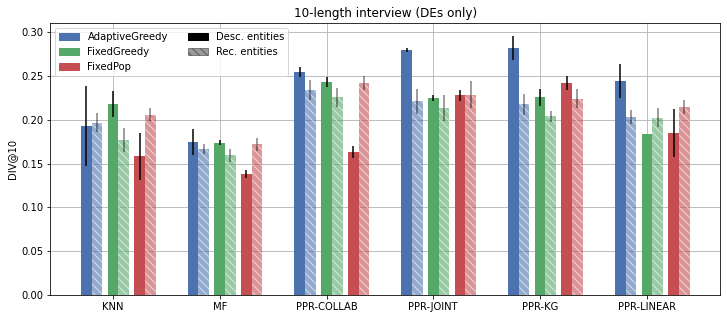

In [91]:
import matplotlib.patches as mpatches

fig_width = 12  # Increase if bars become to small to see 
fig_height = 5
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

ind = np.arange(len(unique_models))
bar_group_width = .25

model_map = {'ppr-linear-learned': 'ppr-linear'}
label_map = {'greedy-adaptive-': 'AdaptiveGreedy', 'greedy-': 'FixedGreedy', 'pop-': 'FixedPop', 'dqn-': 'DQN', 'ddpg-': 'DDPG'}

legend_handles = []

for idx, kind in enumerate(interviewer_kinds):
    
    # Descriptive entity interview performance
    y = [np.mean(data[f'{kind}{model}'][n_questions - 1]) for model in unique_models]
    y_std = [np.std(data[f'{kind}{model}'][n_questions - 1]) for model in unique_models]
    
    # Recommendable entity interview performance
    y_rec = [np.mean(data[f'{kind}{model}-rec'][n_questions - 1]) for model in unique_models]
    y_rec_std = [np.std(data[f'{kind}{model}-rec'][n_questions - 1]) for model in unique_models]
    
    # Calculate indentation
    bar_width_fraction = 0.4  # Decrease to increase spacing between bar pairs - 0.5 leaves no space 
    bar_width = bar_group_width * bar_width_fraction
    descriptive_indent = ind + idx * bar_group_width
    recommendable_indent = descriptive_indent + bar_width

    # Create bar pair 
    ax.bar(descriptive_indent, y, width=bar_width, yerr=y_std, color=f'C{idx}', zorder=3)
    ax.bar(recommendable_indent, y_rec, alpha=0.6, width=bar_width, zorder=3, 
           yerr=y_rec_std, color=f'C{idx}', ecolor=(0,0,0,0.5), 
           edgecolor='white', linewidth=0, hatch='\\\\\\')
    
    # Store the legend handles so we can add some more manually later
    legend_handles.append(mpatches.Patch(color=f'C{idx}', label=label_map.get(kind)))
    
model_displays = [model.replace('-rec', '') for model in unique_models]
model_displays = map(lambda model: model_map.get(model, model).upper(), model_displays)

ax.set_xticks(ind + bar_group_width)
ax.set_xticklabels(model_displays)
plt.ylabel(f'{metric.upper()}@{cutoff}')
interview_kind = 'DE' if de_only else 'RE'
plt.title(f'{n_questions}-length interview ({interview_kind}s only)')

nothing = mpatches.Patch(color=(1,1,1))
full_black = mpatches.Patch(color=(0,0,0, 1.), label='Desc. entities')
transparent_black = mpatches.Patch(color=(0,0,0, .4), label='Rec. entities', hatch='\\\\\\')

plt.legend(handles=legend_handles + [full_black, transparent_black], loc='upper left', ncol=2)

plt.grid(True, zorder=0)
plt.savefig(f'output/{experiment_subset}_{interview_kind.lower()}_{metric}{cutoff}_interviewer_comparison.pdf', bbox_inches='tight')
plt.show()